# Project EDA
-------------
*   자율 주행 데이터에 대한 데이터 분석을 해보고자 한다.
*   yolo, coco, voc 형태도 아닌 독자적인 형태를 가지고 있기 때문에 파싱을 우선적으로 구현해야한다.
*   파싱을 수행하기 위해 json을 읽어 어떤 형태인지 확인 한다.

In [1]:
import os
import glob
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("seaborn")
sns.set(font_scale=2.5)
colors = sns.color_palette("muted", 10)
plt.rc('font', family='NanumBarunGothic')

import warnings
import missingno as msno
warnings.filterwarnings("ignore")
%matplotlib inline


### Data Check

In [2]:
# 5470개의 데이터가 존재
json_files = glob.glob("../output/Labeled Data/*/*/*.json")
print(len(json_files))

5470


In [3]:
# 신규 데이터에는 dataInfo, annotation만 있지만
# 기존 데이터에는 metaData, Situationinfo, labelinginfo_scene representation, imageinfo, info 이렇게 있다.
# 서로 다르게 parsing을 해줘야 한다. (dict.keys 가 2개 또는 5개를 이용하여)
# datainfo == Situationinfo랑 같은 포지션
json_key_set = set()
for j in json_files:
    with open(j, 'r') as f:
        data = json.load(f)
        json_key_set.add(str(data.keys()))
print(json_key_set)

{"dict_keys(['metaData', 'Situationinfo', 'labelinginfo_scene representation', 'imageinfo', 'info'])", "dict_keys(['dataInfo', 'annotation'])"}


In [119]:
# 상황인지는 필요 없기 때문에 딱히 쓰지 않는다.
situation_frame = {
    "목적지": [],
    "목적지 종류":[],
    "상황복잡도":[],
}
object_frame = []
s = set()
for j in json_files:
    with open(j, 'r') as f:
        data = json.load(f)
    # polygon 형태인 경우
    if len(data.keys()) == 2:
        for d in data['annotation']:
            new = {}
            try:
                new['label'] = d['polygon']['label']
                j = j.replace('Labeled Data', 'Source Data')
                new["img_path"] = os.path.splitext(j)[0] + ".jpg"
                new["semantic_path"] = os.path.splitext(j)[0] + '_semantic.jpg'
                new.update(d['polygon']['value'])
            except:
                pass
            object_frame.append(new)
                
    else:
        pass
    
df_object = pd.DataFrame(object_frame)
df_object.head()

,label,img_path,semantic_path,바닥 색상,바닥 상태,바닥 이동속도,벽 색상,벽 위치,사물 속성,사물 색상,...,사람 자세,사람 움직임,사람 위치,사람 키,사람 속도,사람 방향,이정표 방향,이정표 속성,#사람(2~10),#이정표(27~28)
0,바닥,../output/Source Data/polygon/polygon/E_T01_00...,../output/Source Data/polygon/polygon/E_T01_00...,회색,매끄러움,일반,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,벽,../output/Source Data/polygon/polygon/E_T01_00...,../output/Source Data/polygon/polygon/E_T01_00...,NaN,NaN,NaN,투명,근거리 정면,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,벽,../output/Source Data/polygon/polygon/E_T01_00...,../output/Source Data/polygon/polygon/E_T01_00...,NaN,NaN,NaN,흰색,우측,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,벽,../output/Source Data/polygon/polygon/E_T01_00...,../output/Source Data/polygon/polygon/E_T01_00...,NaN,NaN,NaN,투명,우측,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,벽,../output/Source Data/polygon/polygon/E_T01_00...,../output/Source Data/polygon/polygon/E_T01_00...,NaN,NaN,NaN,혼합색,좌측,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 시각화 코드

In [121]:

import cv2
def show_image(Image, Picture_Name):
    plt.figure(figsize=(18,8))
    plt.imshow(Image)
    plt.title(Picture_Name)
    plt.show()
    
def sample_df_by_label(df, n_sample, label, use_frac=False):
    cond = (df['label']==label)
    df = df.loc[cond]
    if use_frac == True:
        df = df.sample(frac=n_sample)
    else:
        df = df.sample(n=n_sample)
    return df

def show_sample_image_by_label(df, n_sample, label):
    df = sample_df_by_label(df, n_sample, label)
    for img, label in zip(df['img_path'], df['label']):
        img = cv2.imread(img)
        show_image(img, label)

def sample_df_by_attr(df, n_sample, attr_name, attr, use_frac=False):
    cond = (df[attr_name] == attr)
    df = df.loc[cond]
    if use_frac == True:
        df = df.sample(frac=n_sample)
    else:
        df = df.sample(n=n_sample)
    return df
        
def show_sample_image_by_attr(df, n_sample, attr_name, attr):
    df = sample_df_by_attr(df, n_sample, attr_name, attr)
    for img, attr in zip(df['img_path'], df[attr_name]):
        print(img)
        img = cv2.imread(img)
        show_image(img, attr)

def sample_all_df_by_attr(df, attr_name, attr, use_frac=False):
    cond = (df[attr_name] == attr)
    df = df.loc[cond]
    return df

def show_sample_image_by_attr_2stage(df, n_sample, attr_name, attr, attr_name2, attr2):
    df = sample_all_df_by_attr(df, attr_name, attr)
    df = sample_df_by_attr(df, n_sample, attr_name2, attr2)
    for img, attr in zip(df['img_path'], df[attr_name]):
        print(img)
        img = cv2.imread(img)
        show_image(img, attr)

### 한글 글꼴 설치

In [5]:
#sudo apt-get install -y fonts-nanum
#sudo fc-cache -fv
#rm ~/.cache/matplotlib -rf

In [6]:
import matplotlib.font_manager as fm
import matplotlib as mpl
f = [f.name for f in fm.fontManager.ttflist if 'Nanum' in f.name]
f

['NanumSquareRound',
 'NanumBarunGothic',
 'NanumGothic',
 'NanumBarunGothic',
 'NanumSquareRound',
 'NanumSquare',
 'NanumGothic',
 'NanumMyeongjo',
 'NanumSquare',
 'NanumMyeongjo',
 'NanumBarunGothic',
 'NanumSquare',
 'NanumMyeongjo',
 'NanumSquare',
 'NanumMyeongjo',
 'NanumGothic',
 'NanumSquareRound',
 'NanumSquareRound',
 'NanumBarunGothic',
 'NanumGothic']

### 결측치 확인

<AxesSubplot:>

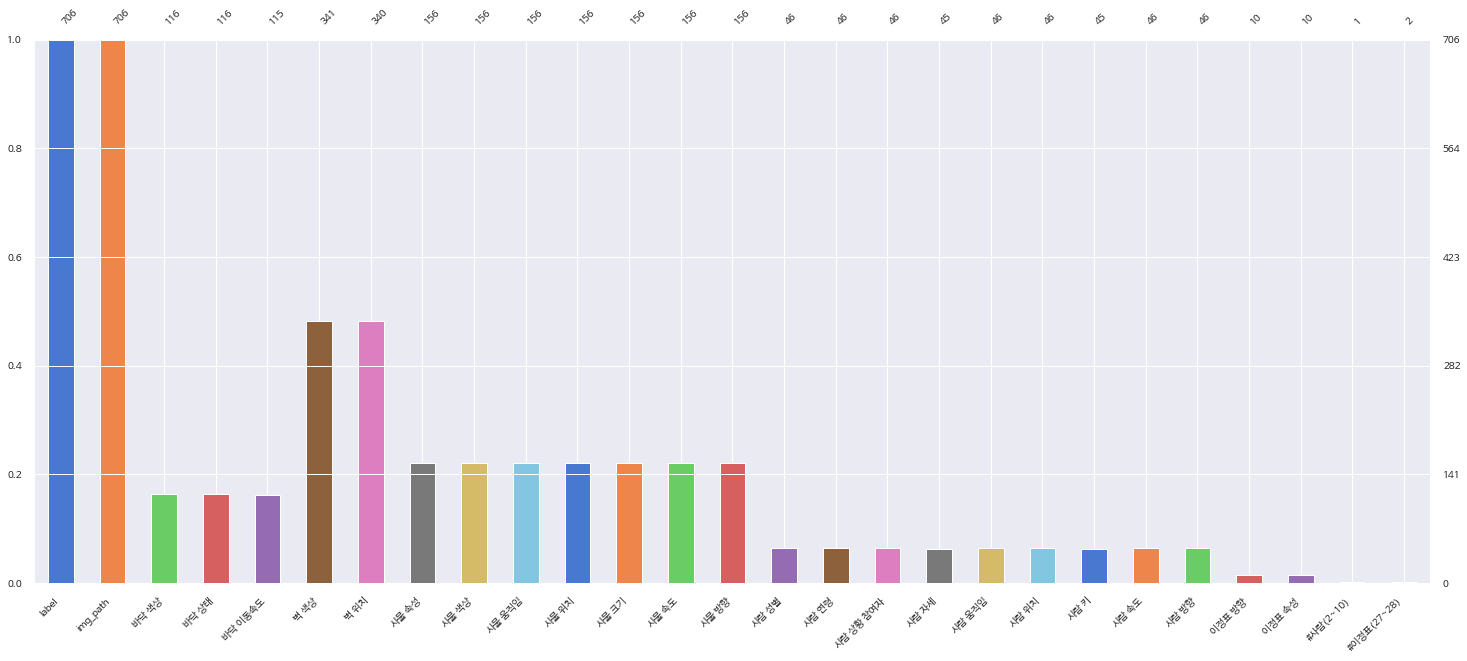

In [7]:
# 결측치는 따로 없다.
msno.bar(df_object, fontsize=10, color=colors)

### 전체 label 비율
*   벽, 사물, 바닥 순서로 많고 이정표는 거의 없다

<AxesSubplot:ylabel='label'>

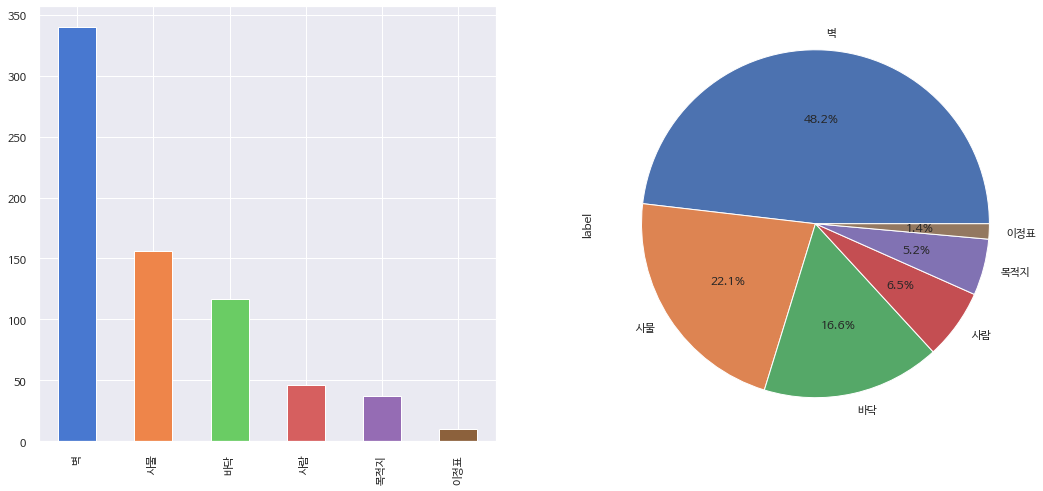

In [8]:
sns.set(font='NanumBarunGothic', font_scale=1.)
f, ax = plt.subplots(1,2,figsize=(18,8))
df_object['label'].value_counts().plot.bar(ax=ax[0], color=colors)
df_object['label'].value_counts().plot.pie(ax=ax[1], autopct="%1.1f%%")

### 벽 속성 조사
*   벽 색상과 위치의 상관도는 없다고 판단하여 서로의 상관관계는 따로 보지 않는다.
*   색상의 경우 가장 많은 혼합색이 가장 많다
*   위치의 경우 class끼리 균형되어 있다

<AxesSubplot:ylabel='None'>

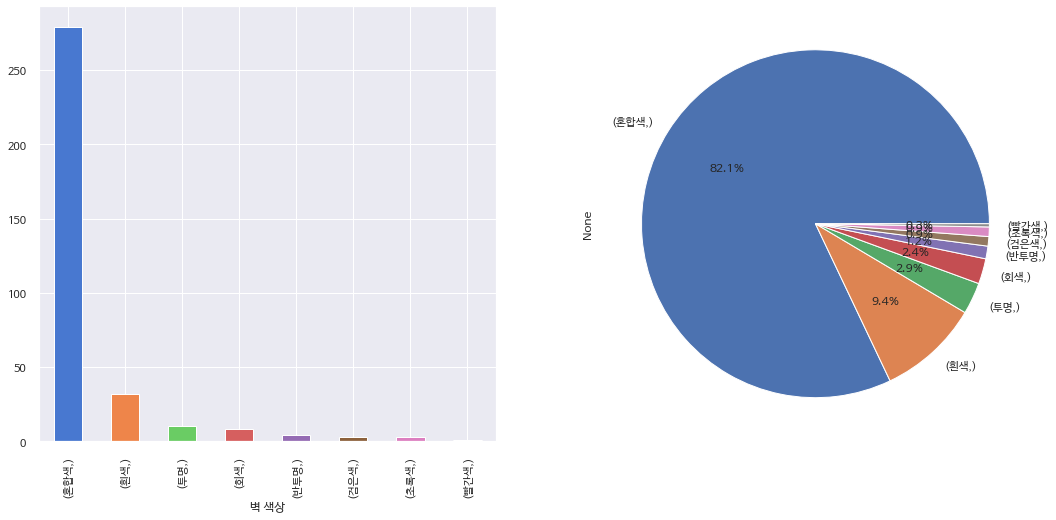

In [9]:
sns.set(font='NanumBarunGothic', font_scale=1.0)
f, ax = plt.subplots(1,2, figsize=(18,8))
idx = df_object['label'] == '벽'
df_object[idx][['벽 색상']].value_counts().plot.bar(ax = ax[0], color=colors)
df_object[idx][['벽 색상']].value_counts().plot.pie(ax = ax[1], autopct="%1.1f%%")


<AxesSubplot:ylabel='None'>

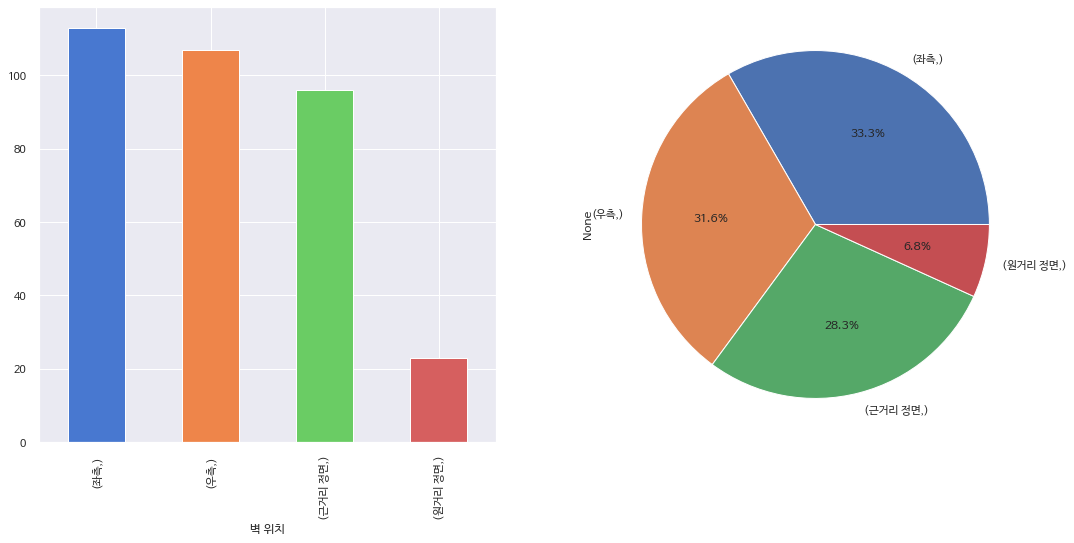

In [10]:
sns.set(font='NanumBarunGothic', font_scale=1.0)
f, ax = plt.subplots(1,2, figsize=(18,8))
idx = df_object['label'] == '벽'
df_object[idx][['벽 위치']].value_counts().plot.bar(ax = ax[0], color=colors)
df_object[idx][['벽 위치']].value_counts().plot.pie(ax = ax[1], autopct="%1.1f%%")

### 사물 속성 조사
--------
*   사물은 사람 다음으로 많은 속성을 가진 객체이기 때문에 상세하게 봐야한다.
*   속성, 색상, 움직임, 위치, 크기, 속도, 방향 속성을 가지고 있다.

<AxesSubplot:ylabel='None'>

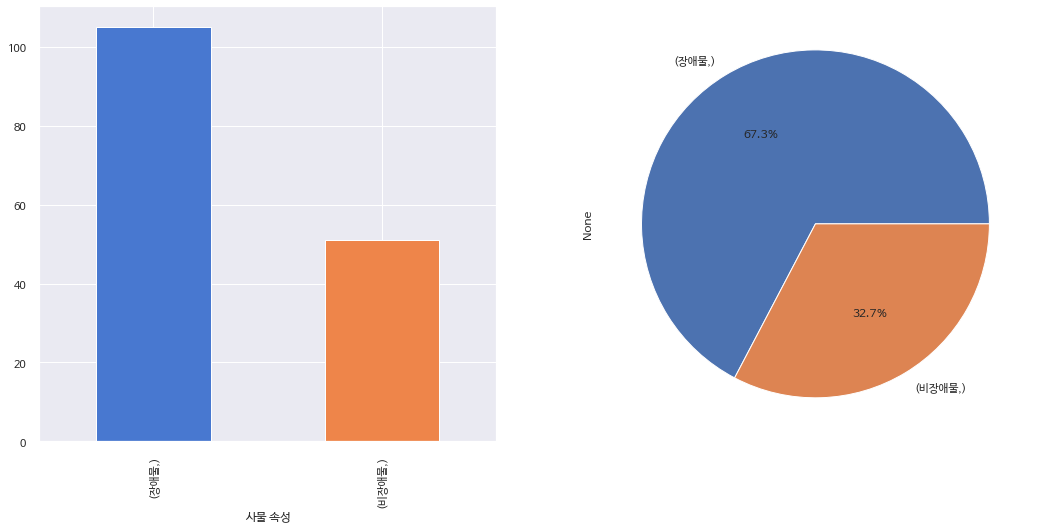

In [17]:
sns.set(font='NanumBarunGothic', font_scale=1.0)
f, ax = plt.subplots(1,2, figsize=(18,8))
idx = df_object['label'] == '사물'
df_object[idx][['사물 속성']].value_counts().plot.bar(ax = ax[0], color=colors)
df_object[idx][['사물 속성']].value_counts().plot.pie(ax = ax[1], autopct="%1.1f%%")


*   사물의 속성은 장애물, 비장애물로 구성되어 있다.
*   사물의 위치에 따라 장애물, 비장애물로 구별될 수 있다고 판단하여 이에 대한 상관관계를 파악해보고자 한다.

<AxesSubplot:xlabel='사물 속성', ylabel='count'>

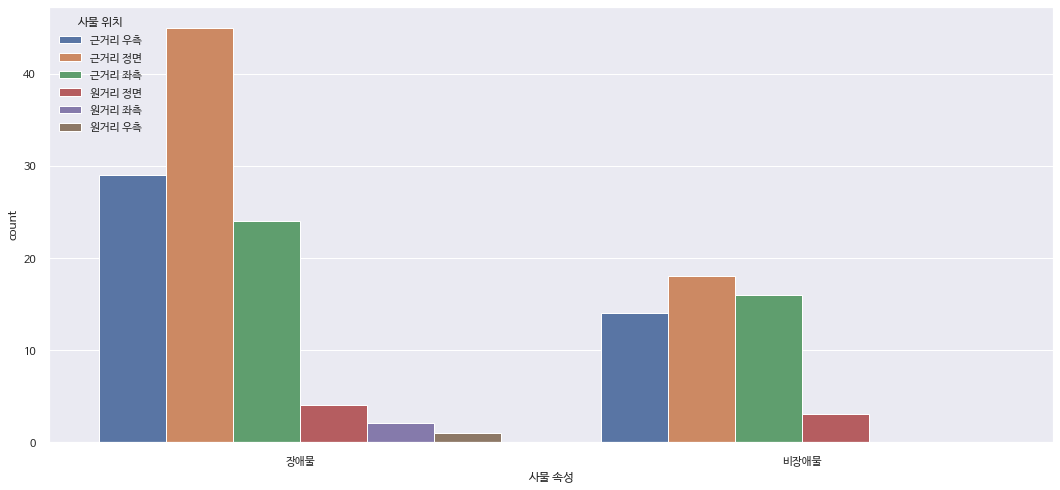

In [72]:
plt.figure(figsize=(18, 8))
idx = df_object["label"] == "사물"
sns.countplot(data=df_object[idx], x="사물 속성", hue="사물 위치")

*   장애물인 경우 대부분이 근거리이다.
*   하지만 비 장애물인 경우에도 근거리가 많기 떄문에 그렇게 크게 상관관계가 있어 보이진 않는다.
*   근거리가 원거리에 비해 데이터가 많기 떄문에 이런 현상을 보이는것 같다.


<AxesSubplot:xlabel='사물 속성', ylabel='count'>

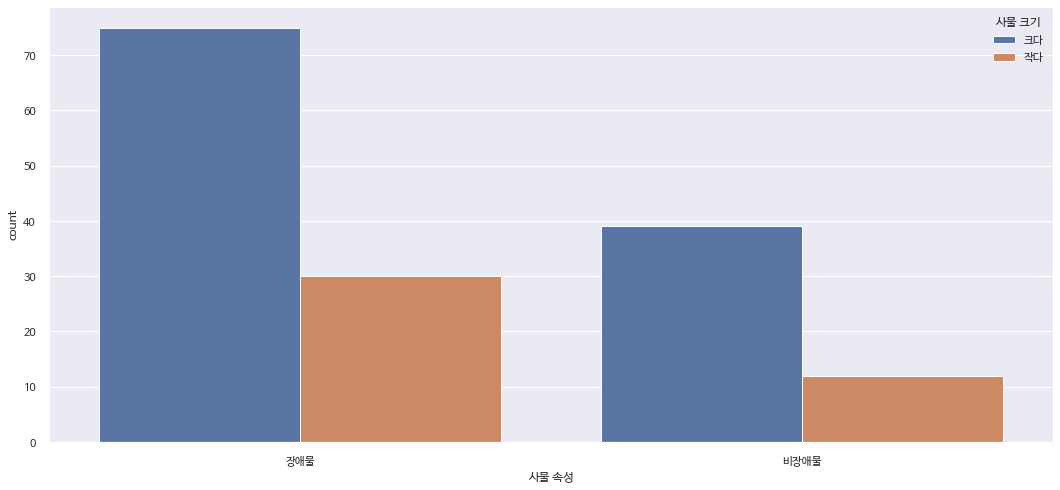

In [73]:
plt.figure(figsize=(18, 8))
idx = df_object["label"] == "사물"
sns.countplot(data=df_object[idx], x="사물 속성", hue="사물 크기")

*   크기 또한 크다 작다에 장애물이 연관되어 보이진 않는다.

<AxesSubplot:xlabel='사물 속성', ylabel='count'>

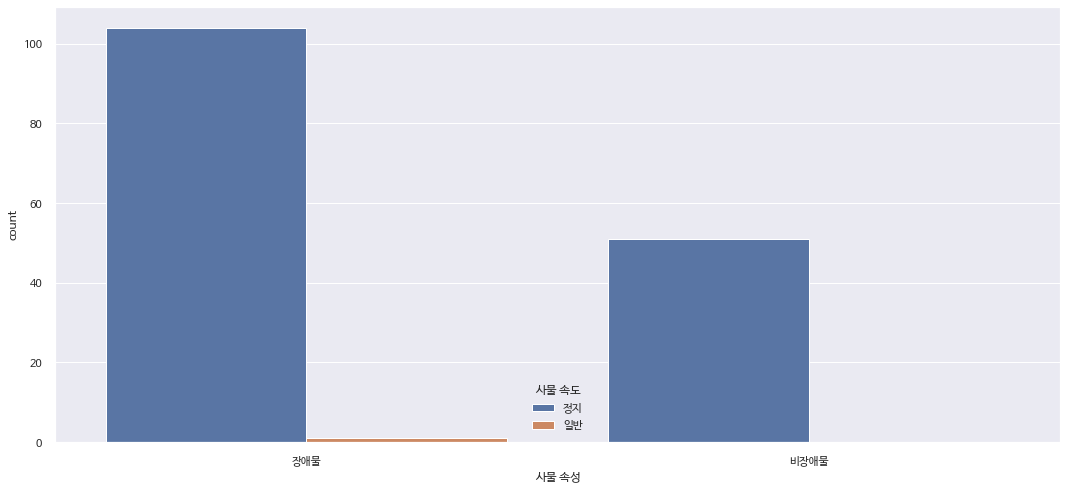

In [74]:
plt.figure(figsize=(18, 8))
idx = df_object["label"] == "사물"
sns.countplot(data=df_object[idx], x="사물 속성", hue="사물 속도")

<AxesSubplot:xlabel='사물 속성', ylabel='count'>

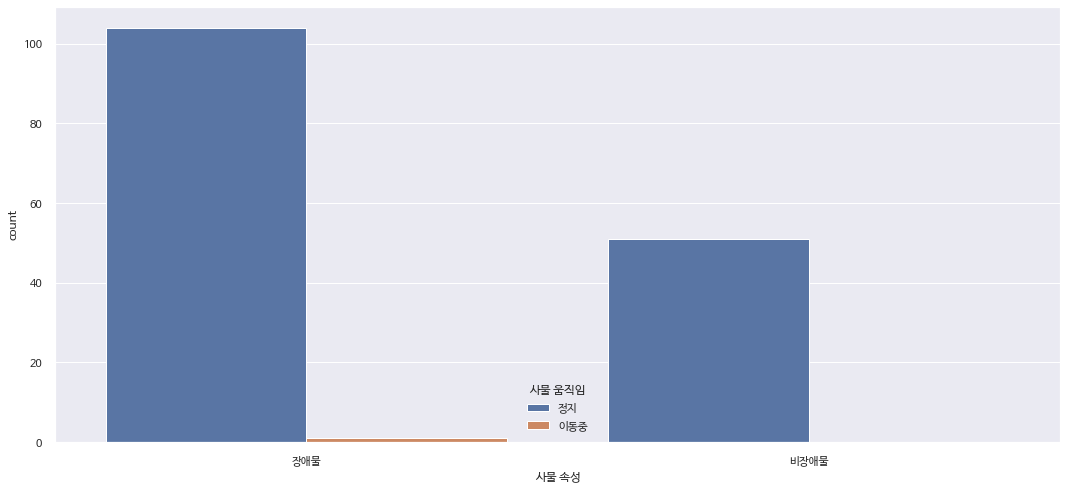

In [75]:
plt.figure(figsize=(18, 8))
idx = df_object["label"] == "사물"
sns.countplot(data=df_object[idx], x="사물 속성", hue="사물 움직임")

<AxesSubplot:xlabel='사물 속성', ylabel='count'>

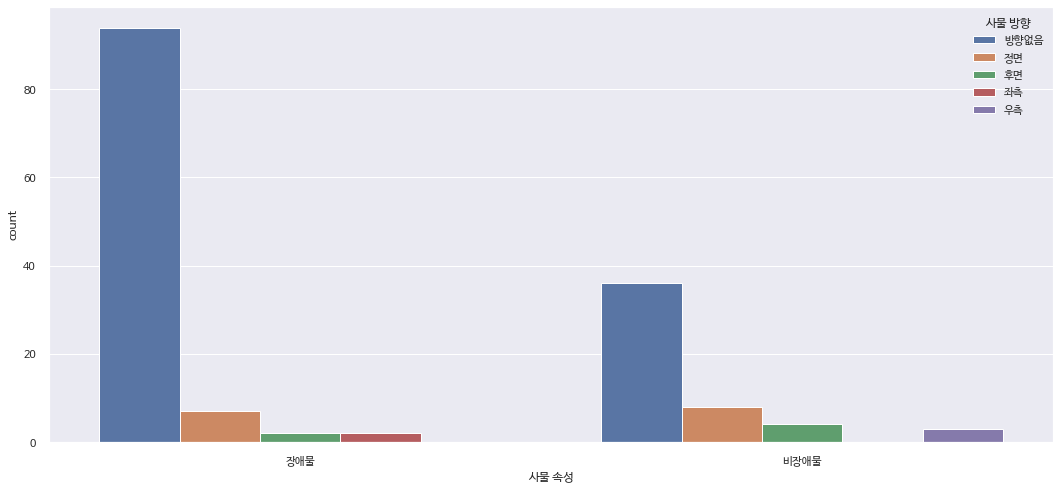

In [76]:
plt.figure(figsize=(18, 8))
idx = df_object["label"] == "사물"
sns.countplot(data=df_object[idx], x="사물 속성", hue="사물 방향")

<AxesSubplot:xlabel='사물 속성', ylabel='count'>

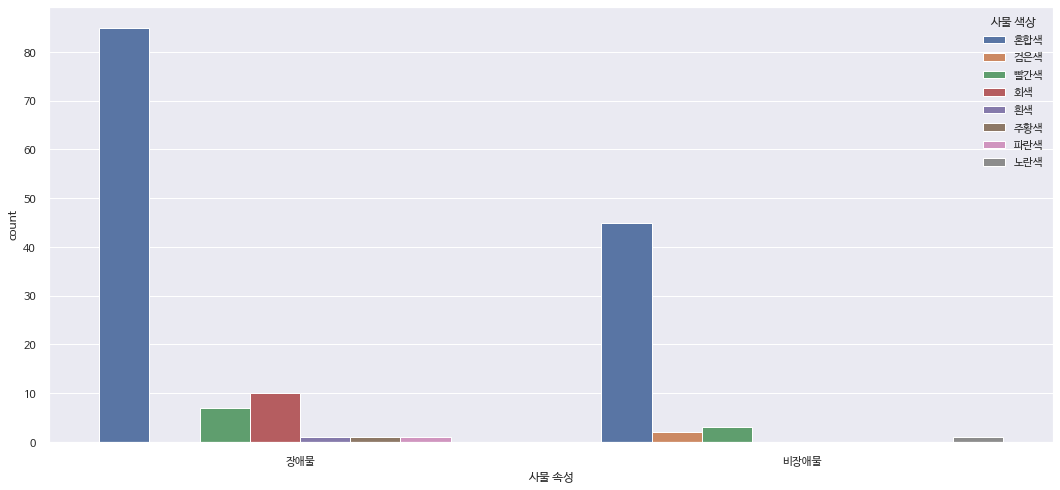

In [102]:
plt.figure(figsize=(18, 8))
idx = df_object["label"] == "사물"
sns.countplot(data=df_object[idx], x="사물 속성", hue="사물 색상")

### 결론: 장애물은 어떤 속성과도 관련이 없어보인다.

<AxesSubplot:ylabel='None'>

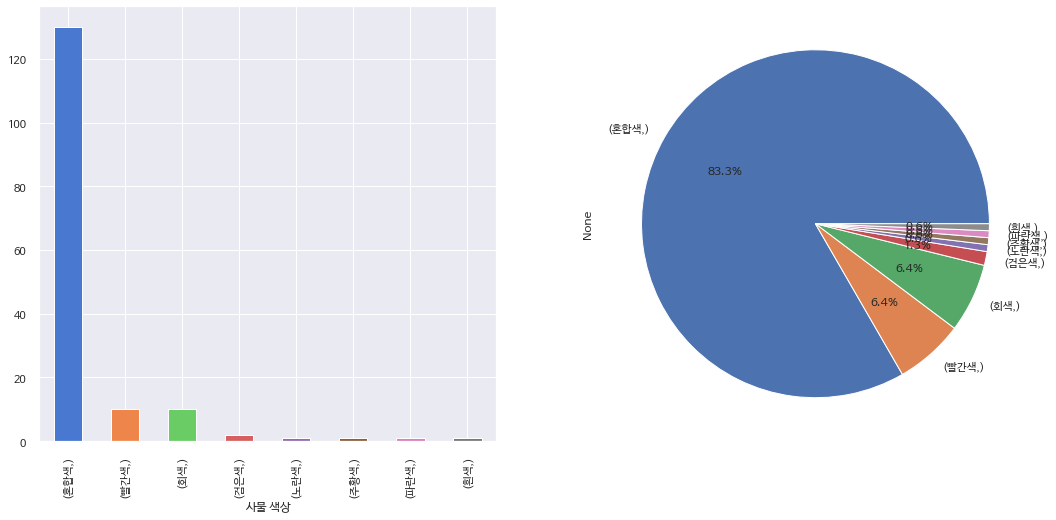

In [84]:
sns.set(font='NanumBarunGothic', font_scale=1.0)
f, ax = plt.subplots(1,2, figsize=(18,8))
idx = df_object['label'] == '사물'
df_object[idx][['사물 색상']].value_counts().plot.bar(ax = ax[0], color=colors)
df_object[idx][['사물 색상']].value_counts().plot.pie(ax = ax[1], autopct="%1.1f%%")


*   사물 움직임이나, 사물 속도는 그냥 모두 정지로 mapping하는게 어떨까 싶다.(0.6%)

<AxesSubplot:ylabel='None'>

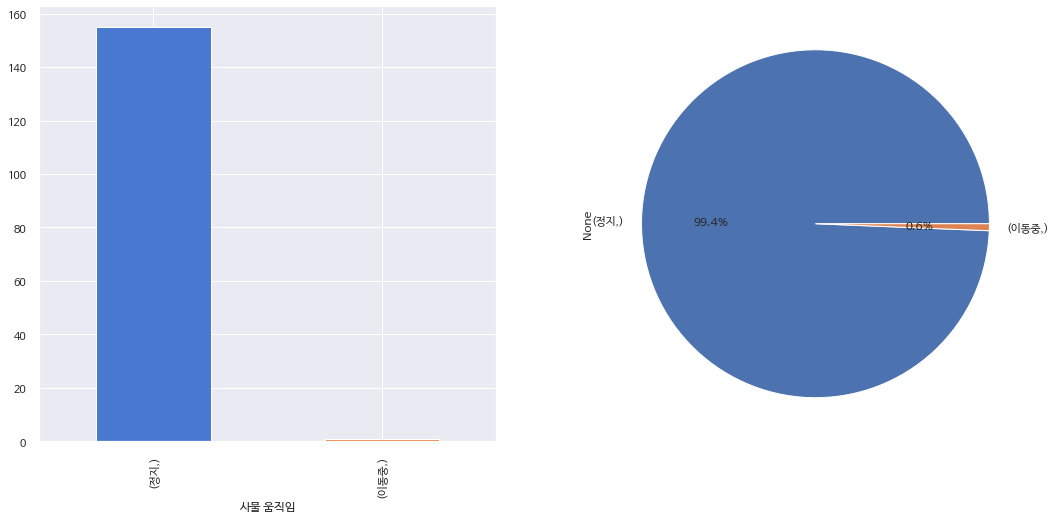

In [78]:
# 사물 움직임이 있으면 사물 속도도 "일반"으로 바뀐다.
sns.set(font='NanumBarunGothic', font_scale=1.0)
f, ax = plt.subplots(1,2, figsize=(18,8))
idx = df_object['label'] == '사물'
df_object[idx][['사물 움직임']].value_counts().plot.bar(ax = ax[0], color=colors)
df_object[idx][['사물 움직임']].value_counts().plot.pie(ax = ax[1], autopct="%1.1f%%")


<AxesSubplot:ylabel='None'>

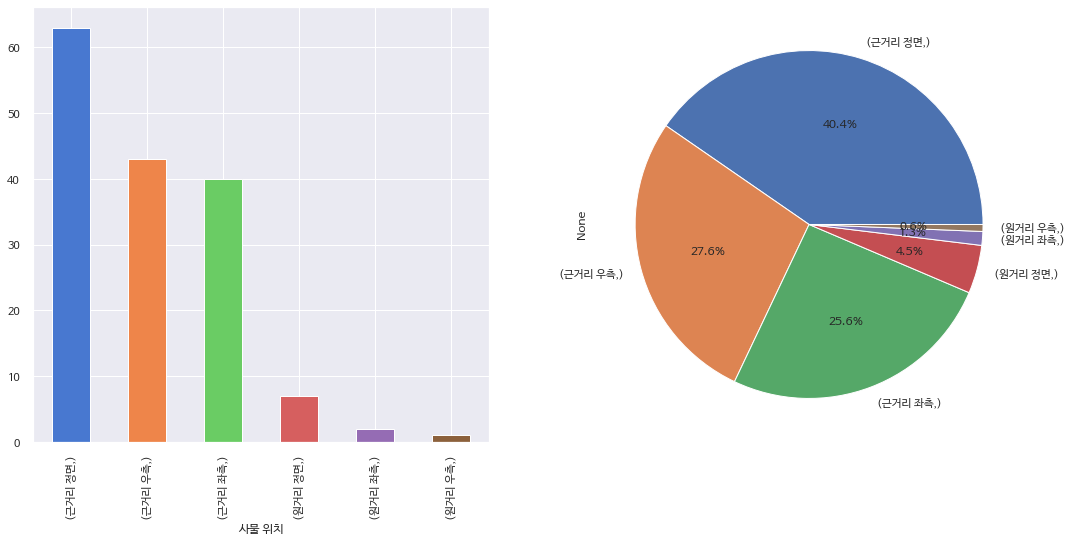

In [85]:
sns.set(font='NanumBarunGothic', font_scale=1.0)
f, ax = plt.subplots(1,2, figsize=(18,8))
idx = df_object['label'] == '사물'
df_object[idx][['사물 위치']].value_counts().plot.bar(ax = ax[0], color=colors)
df_object[idx][['사물 위치']].value_counts().plot.pie(ax = ax[1], autopct="%1.1f%%")

<AxesSubplot:ylabel='None'>

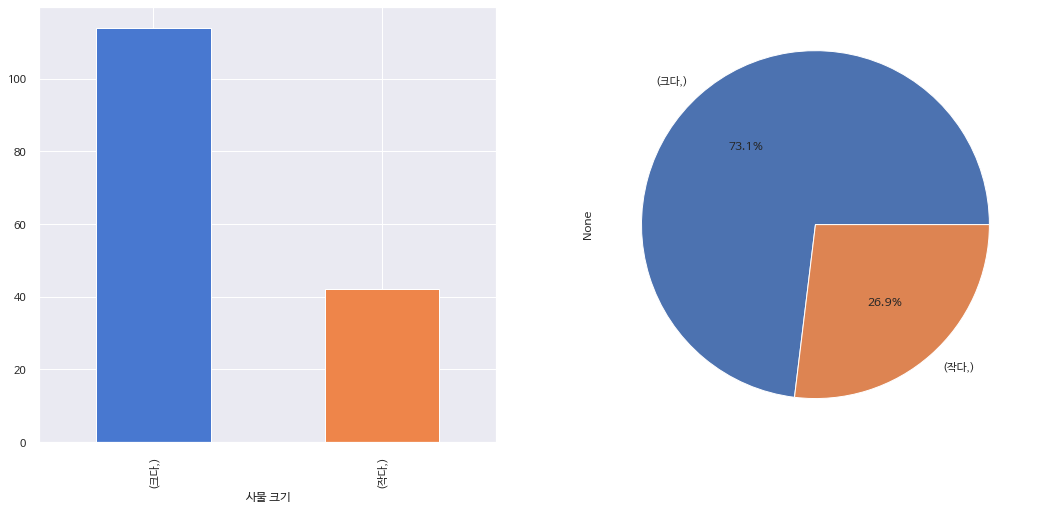

In [86]:
# 사물 움직임이 있으면 사물 속도도 "일반"으로 바뀐다.
sns.set(font='NanumBarunGothic', font_scale=1.0)
f, ax = plt.subplots(1,2, figsize=(18,8))
idx = df_object['label'] == '사물'
df_object[idx][['사물 크기']].value_counts().plot.bar(ax = ax[0], color=colors)
df_object[idx][['사물 크기']].value_counts().plot.pie(ax = ax[1], autopct="%1.1f%%")


*   방향 속성은 사물의 움직임이 있을때만 annotation되는 것이 아니다.
*   방향은 어떤 좌표든 다 존재하는데 방향없음이 대부분이다
*   실제로 방향없음인데도 불구하고 방향이 있을 여지가 있기 때문에 이건 맞추기가 어렵다.

<AxesSubplot:ylabel='None'>

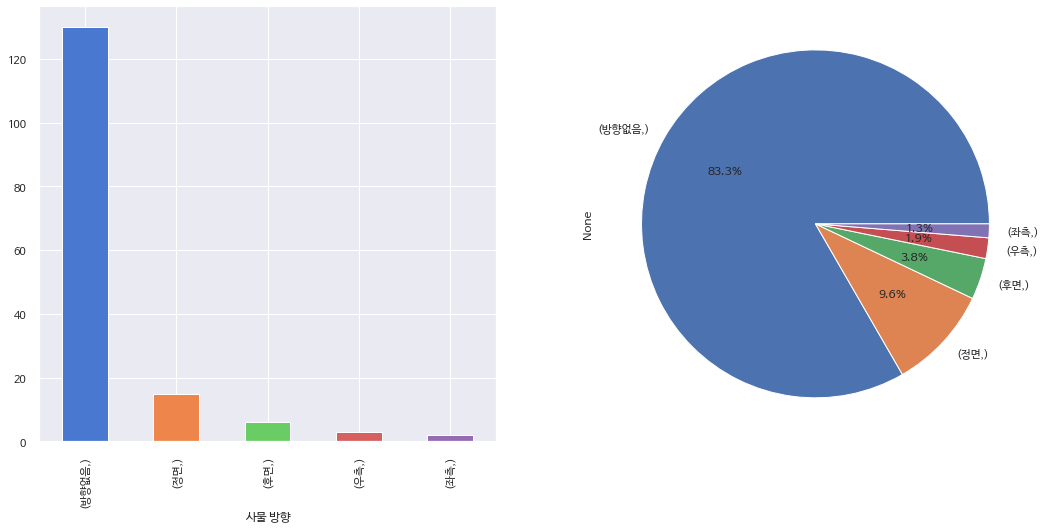

In [88]:
sns.set(font='NanumBarunGothic', font_scale=1.0)
f, ax = plt.subplots(1,2, figsize=(18,8))
idx = df_object['label'] == '사물'
df_object[idx][['사물 방향']].value_counts().plot.bar(ax = ax[0], color=colors)
df_object[idx][['사물 방향']].value_counts().plot.pie(ax = ax[1], autopct="%1.1f%%")


../output/Source Data/polygon/polygon/E_T01_000963_P001_semantic.jpg


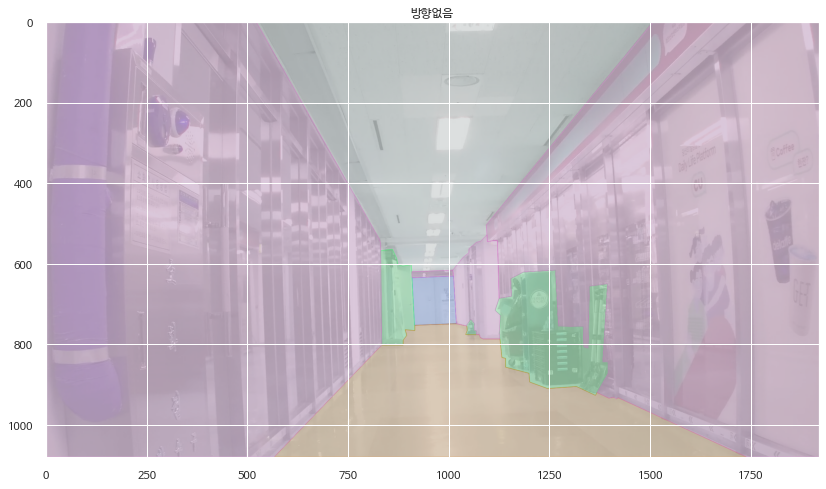

In [101]:
# 해당 이미지에 annotation을 본 결과 모두 방향이 없다고 나왔다.
show_sample_image_by_attr(df_object, 1, "사물 방향", "방향없음")


### 사람 속성 파악
*   사람은 가장 많은 속성을 가지고 있는 객체이다.
*   성별, 연령, 상황 참여자, 자세, 움직임, 위치, 키, 속도, 방향 이 있다.

<AxesSubplot:ylabel='None'>

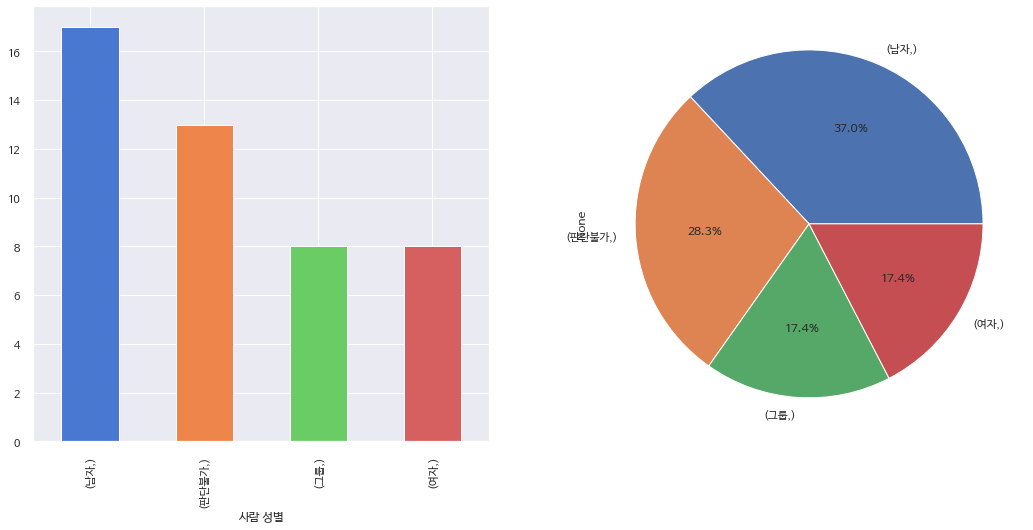

In [103]:
# 남자가 주를 이루고 그룹과 여자가 같은 비중을 차지하고 있다.
sns.set(font='NanumBarunGothic', font_scale=1.0)
f, ax = plt.subplots(1,2, figsize=(18,8))
idx = df_object['label'] == '사람'
df_object[idx][['사람 성별']].value_counts().plot.bar(ax = ax[0], color=colors)
df_object[idx][['사람 성별']].value_counts().plot.pie(ax = ax[1], autopct="%1.1f%%")


<AxesSubplot:ylabel='None'>

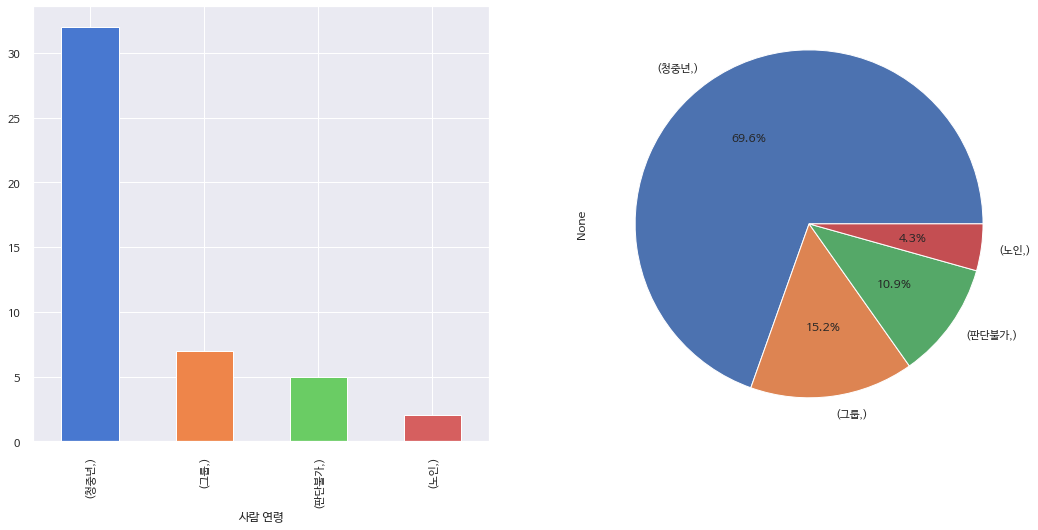

In [104]:
sns.set(font='NanumBarunGothic', font_scale=1.0)
f, ax = plt.subplots(1,2, figsize=(18,8))
idx = df_object['label'] == '사람'
df_object[idx][['사람 연령']].value_counts().plot.bar(ax = ax[0], color=colors)
df_object[idx][['사람 연령']].value_counts().plot.pie(ax = ax[1], autopct="%1.1f%%")

<AxesSubplot:ylabel='None'>

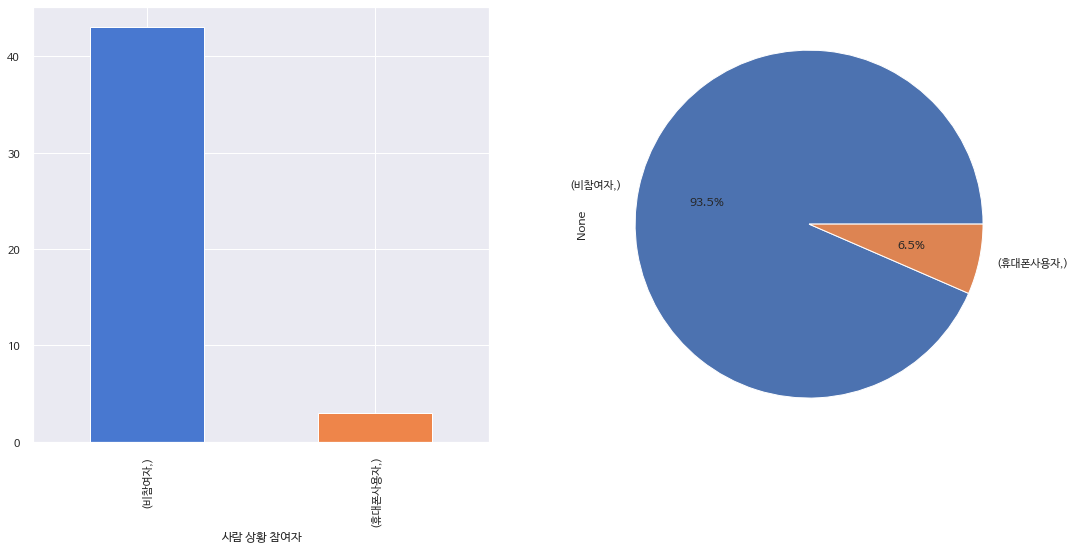

In [105]:
# 상황 참여자는 labeling이 헷갈리지만 휴대폰사용, 비사용 으로 나누어져 있다.
sns.set(font='NanumBarunGothic', font_scale=1.0)
f, ax = plt.subplots(1,2, figsize=(18,8))
idx = df_object['label'] == '사람'
df_object[idx][['사람 상황 참여자']].value_counts().plot.bar(ax = ax[0], color=colors)
df_object[idx][['사람 상황 참여자']].value_counts().plot.pie(ax = ax[1], autopct="%1.1f%%")

<AxesSubplot:ylabel='None'>

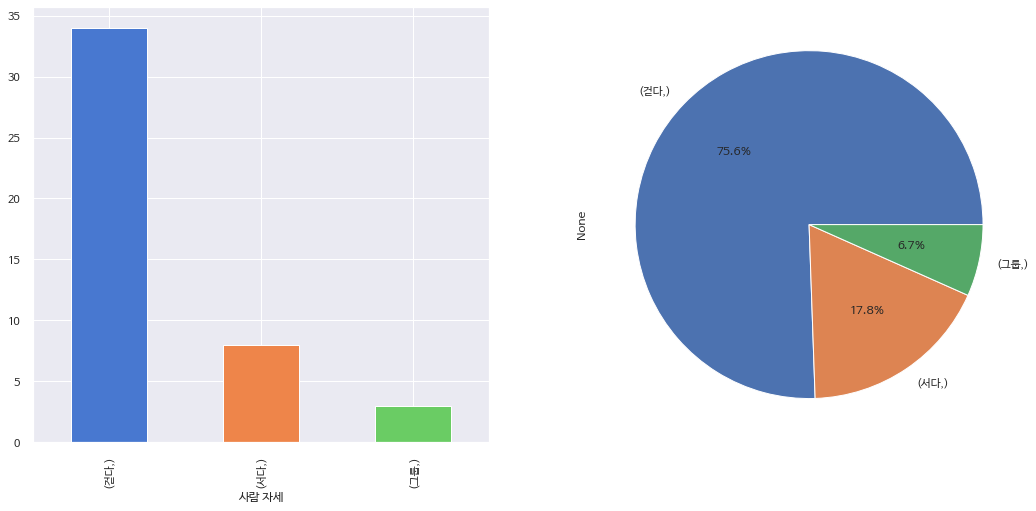

In [106]:
# 자세가 그룹인경우는 어떤 경우인지 모르겠다.
sns.set(font='NanumBarunGothic', font_scale=1.0)
f, ax = plt.subplots(1,2, figsize=(18,8))
idx = df_object['label'] == '사람'
df_object[idx][['사람 자세']].value_counts().plot.bar(ax = ax[0], color=colors)
df_object[idx][['사람 자세']].value_counts().plot.pie(ax = ax[1], autopct="%1.1f%%")

../output/Source Data/polygon/polygon/E_T01_000056_P025_semantic.jpg


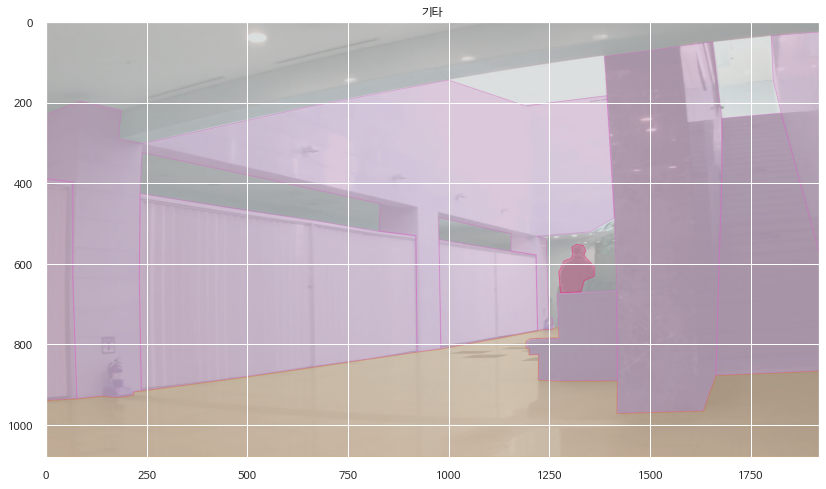

In [113]:
show_sample_image_by_attr(df_object, 1, "사람 움직임", "기타")

<AxesSubplot:ylabel='None'>

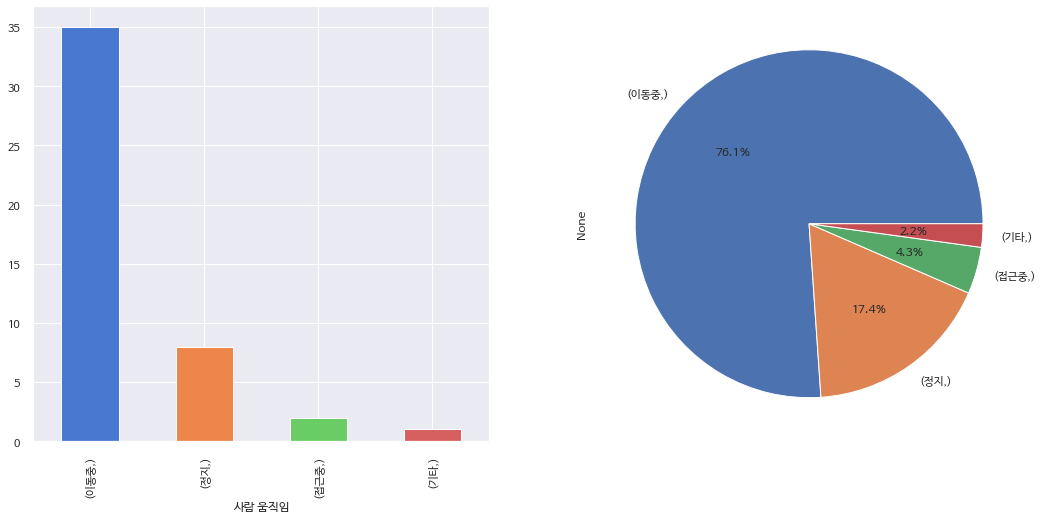

In [107]:
# 이동중에 접근중, 기타가 포함되어 있기 때문에 이동중에 모두 포함하는건 어떨까?
# 접근중이 2개의 이미지인데 모두 엄청 멀리에 있는 경우이기 때문에 이동중으로 간주해도 별 상관 없어 보인다.
sns.set(font='NanumBarunGothic', font_scale=1.0)
f, ax = plt.subplots(1,2, figsize=(18,8))
idx = df_object['label'] == '사람'
df_object[idx][['사람 움직임']].value_counts().plot.bar(ax = ax[0], color=colors)
df_object[idx][['사람 움직임']].value_counts().plot.pie(ax = ax[1], autopct="%1.1f%%")

<AxesSubplot:ylabel='None'>

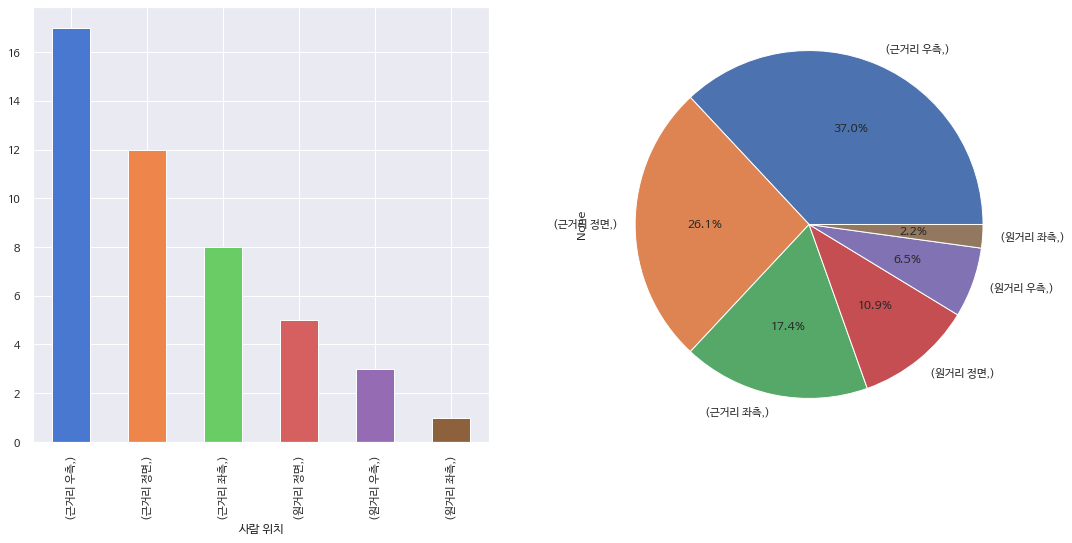

In [114]:
# 위치의 경우 약간 unbalance한 결과가 나왔지만 데이터를 수집하다 보면, 정면, 우측, 좌측은 비중이 맞을것으로 보인다.
sns.set(font='NanumBarunGothic', font_scale=1.0)
f, ax = plt.subplots(1,2, figsize=(18,8))
idx = df_object['label'] == '사람'
df_object[idx][['사람 위치']].value_counts().plot.bar(ax = ax[0], color=colors)
df_object[idx][['사람 위치']].value_counts().plot.pie(ax = ax[1], autopct="%1.1f%%")

<AxesSubplot:ylabel='None'>

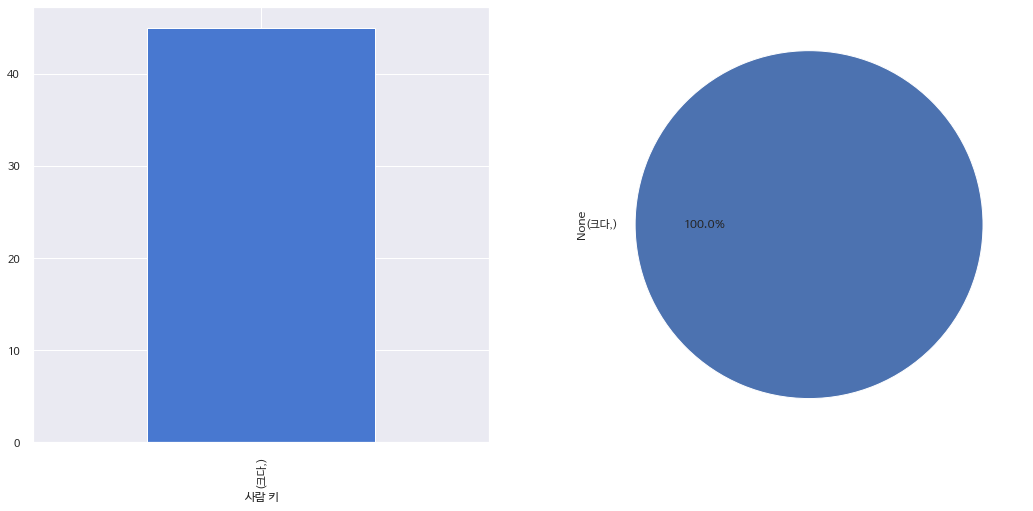

In [115]:
# 사람키는 사람 구별 중에 어린이가 없었기 때문에 모두 크다로 annotation된것 같다.
sns.set(font='NanumBarunGothic', font_scale=1.0)
f, ax = plt.subplots(1,2, figsize=(18,8))
idx = df_object['label'] == '사람'
df_object[idx][['사람 키']].value_counts().plot.bar(ax = ax[0], color=colors)
df_object[idx][['사람 키']].value_counts().plot.pie(ax = ax[1], autopct="%1.1f%%")

<AxesSubplot:ylabel='None'>

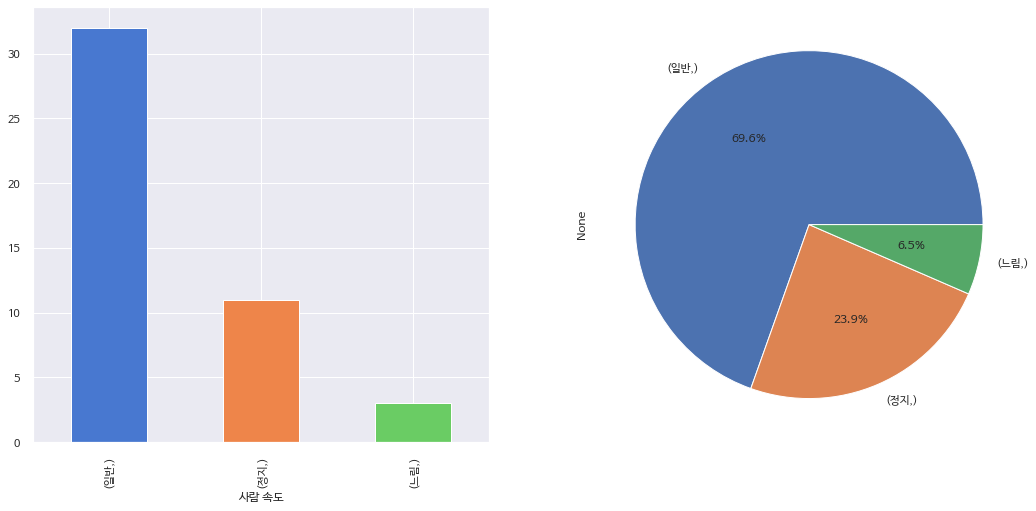

In [116]:
sns.set(font='NanumBarunGothic', font_scale=1.0)
f, ax = plt.subplots(1,2, figsize=(18,8))
idx = df_object['label'] == '사람'
df_object[idx][['사람 속도']].value_counts().plot.bar(ax = ax[0], color=colors)
df_object[idx][['사람 속도']].value_counts().plot.pie(ax = ax[1], autopct="%1.1f%%")

<AxesSubplot:xlabel='사람 자세', ylabel='count'>

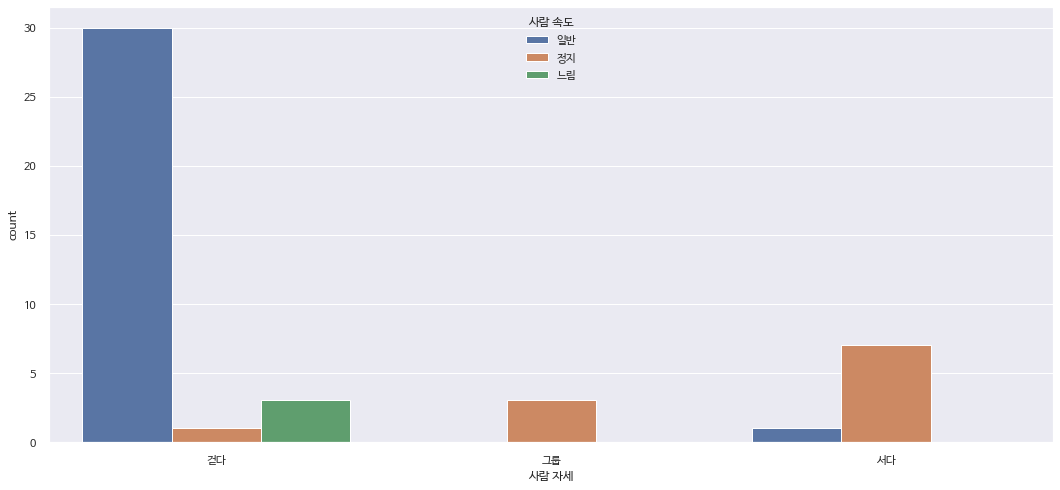

In [118]:
# 사람이 서 있는데 속도가 일반인 경우나, 사람이 걷는데 정지 상태인 경우가 있다.
plt.figure(figsize=(18, 8))
idx = df_object["label"] == "사람"
sns.countplot(data=df_object[idx], x="사람 자세", hue="사람 속도")

../output/Source Data/polygon/polygon/E_T01_000743_P018.jpg


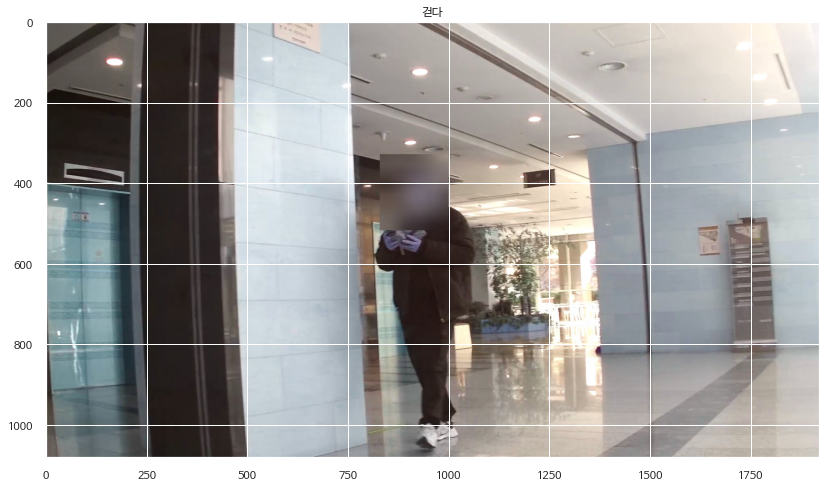

../output/Source Data/polygon/polygon/E_T01_000920_P002.jpg


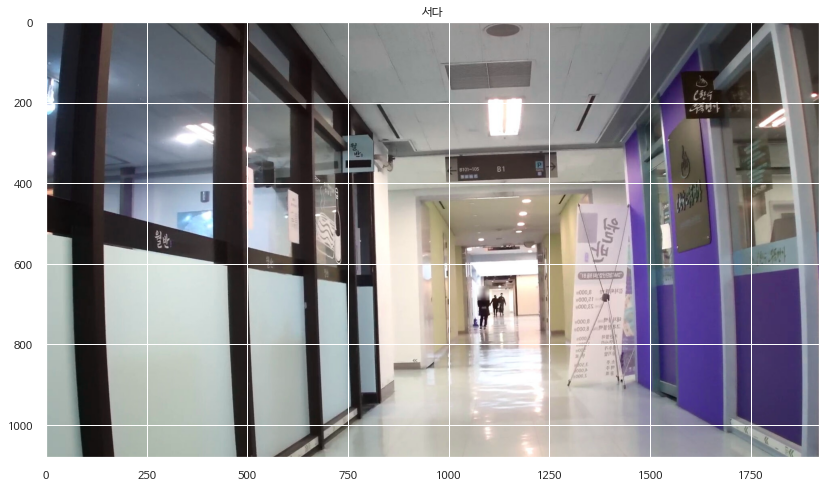

In [123]:
# 이미지를 보니 사람 자세가 속도보다 더 잘 맞는다.
show_sample_image_by_attr_2stage(df_object, 1, "사람 자세", "걷다", "사람 속도", "정지")
show_sample_image_by_attr_2stage(df_object, 1, "사람 자세", "서다", "사람 속도", "일반")

<AxesSubplot:xlabel='사람 위치', ylabel='count'>

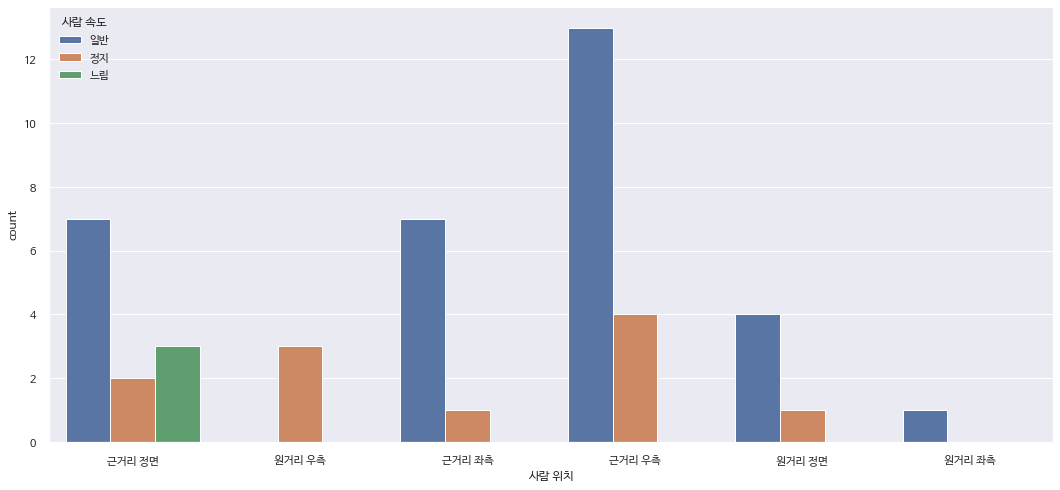

In [124]:
# 사람 속도가 느린 경우 원거리에 있어서 느리다고 판단한줄 알았지만 오히려 근거리에만 느림이 존재
# 어떤 기준으로 사람 속도를 판단하는건지 잘 모르겠음.
plt.figure(figsize=(18, 8))
idx = df_object["label"] == "사람"
sns.countplot(data=df_object[idx], x="사람 위치", hue="사람 속도")

<AxesSubplot:xlabel='사람 연령', ylabel='count'>

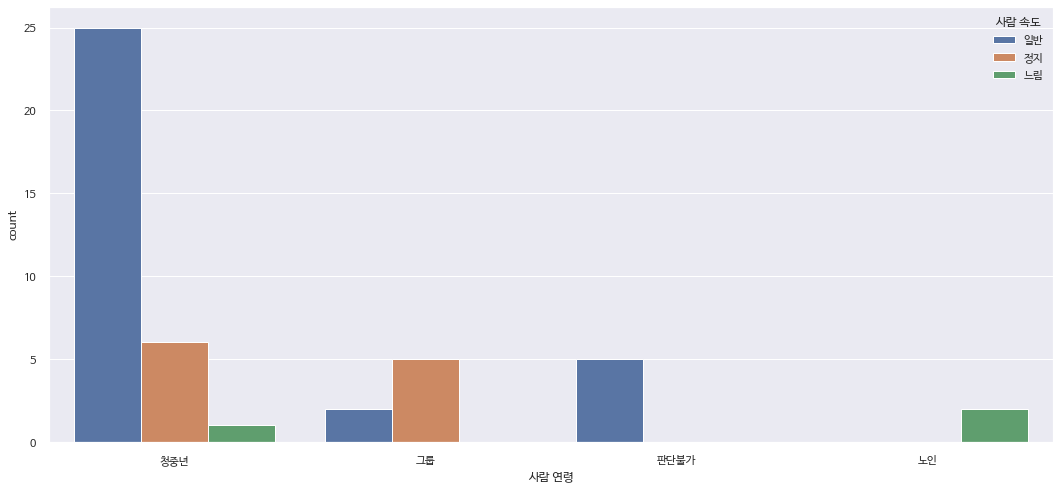

In [126]:
# 노인의 경우 사람을 다 느림으로 판단한것으로 하였음.
plt.figure(figsize=(18, 8))
idx = df_object["label"] == "사람"
sns.countplot(data=df_object[idx], x="사람 연령", hue="사람 속도")

../output/Source Data/polygon/polygon/E_T01_000975_P002.jpg


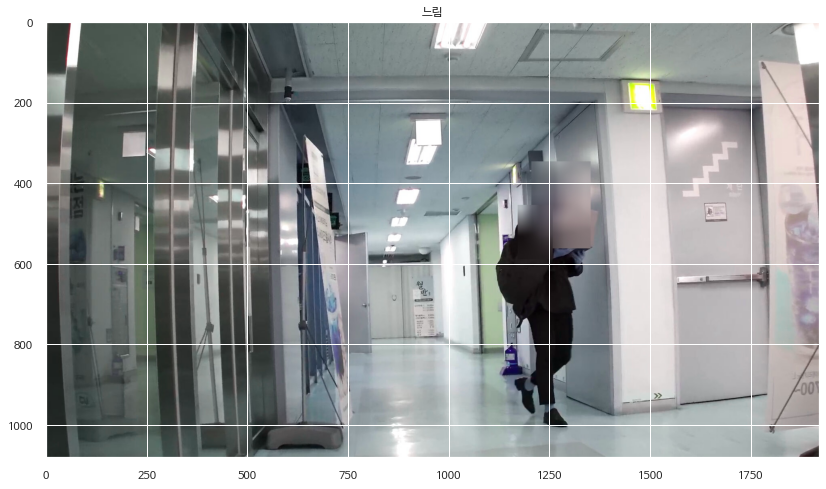

In [127]:
# 청중년인데도 느린경우인데 "일반"에 가까운것으로 보인다.
show_sample_image_by_attr_2stage(df_object, 1, "사람 속도", "느림", "사람 연령", "청중년")

<AxesSubplot:ylabel='None'>

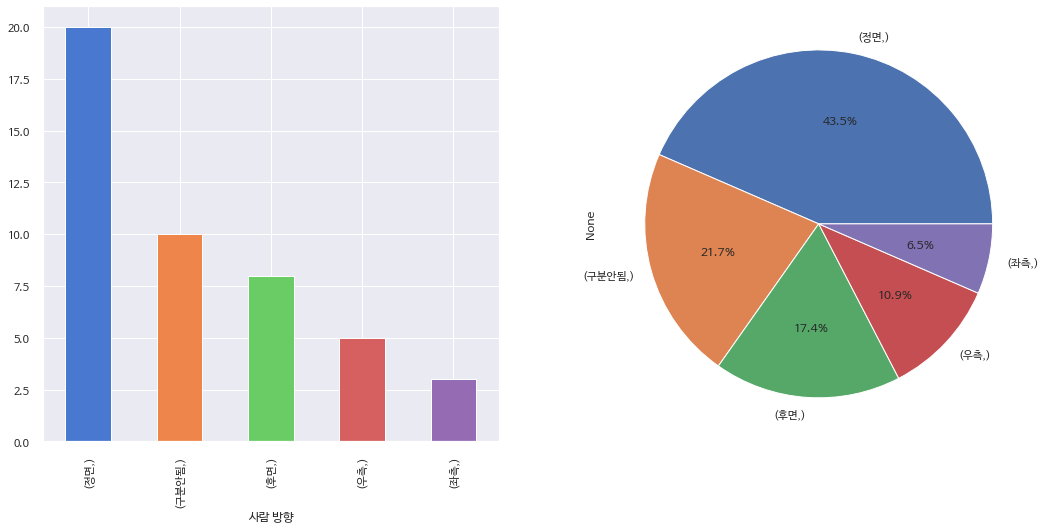

In [117]:
sns.set(font='NanumBarunGothic', font_scale=1.0)
f, ax = plt.subplots(1,2, figsize=(18,8))
idx = df_object['label'] == '사람'
df_object[idx][['사람 방향']].value_counts().plot.bar(ax = ax[0], color=colors)
df_object[idx][['사람 방향']].value_counts().plot.pie(ax = ax[1], autopct="%1.1f%%")

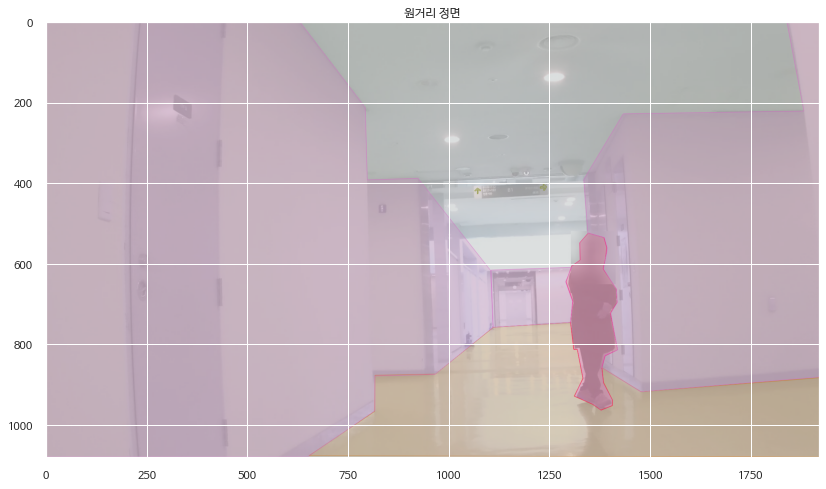

In [14]:
# 가장 멀리있는 벽이 원거리 정면인듯 보인다.
show_sample_image_by_attr(df_object, 1, "벽 위치", "원거리 정면")

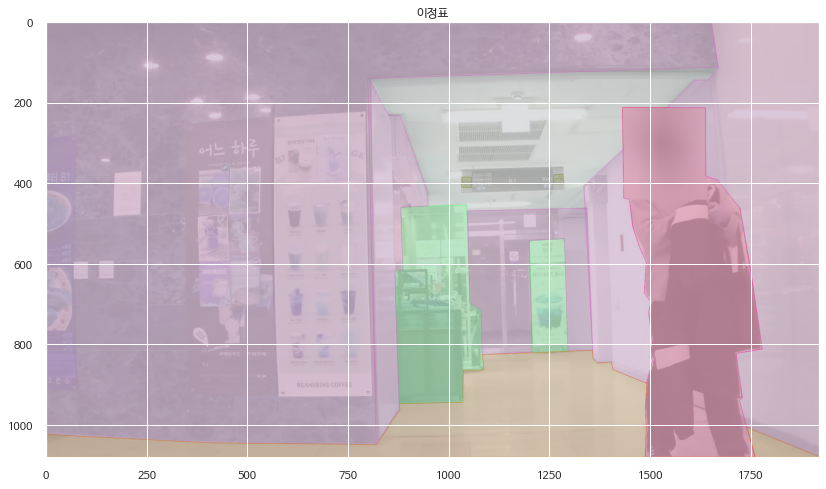

In [16]:
# 이정표는 천장 위에 붙어있는 안내 장치를 이정표라고 부름.
show_sample_image_by_label(df_object, 1, "이정표")